<a href="https://colab.research.google.com/github/quimHM/QHM_TFG_repository/blob/main/MAB_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#https://towardsdatascience.com/multi-armed-bandits-and-reinforcement-learning-dc9001dcb8da
#https://towardsdatascience.com/the-upper-confidence-bound-ucb-bandit-algorithm-c05c2bf4c13f

#https://github.com/WhatIThinkAbout/BabyRobot/tree/master/Multi_Armed_Bandits

In [3]:
# import modules 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
%matplotlib inline

In [4]:
class eps_bandit:
    '''
    epsilon-greedy k-bandit problem
    
    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0. 
        Set to "sequence" for the means to be ordered from 
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    '''
    
    def __init__(self, k, eps, iters, mu='random'):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)
        
        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages            
            self.mu = np.array(mu)
        elif mu == 'random':
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == 'sequence':
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k-1, k)
        
    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)
            
        reward = np.random.normal(self.mu[a], 1)
        
        # Update counts
        self.n += 1
        self.k_n[a] += 1
        
        # Update total
        self.mean_reward = self.mean_reward + (
            reward - self.mean_reward) / self.n
        
        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (
            reward - self.k_reward[a]) / self.k_n[a]
        
    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward
            
    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

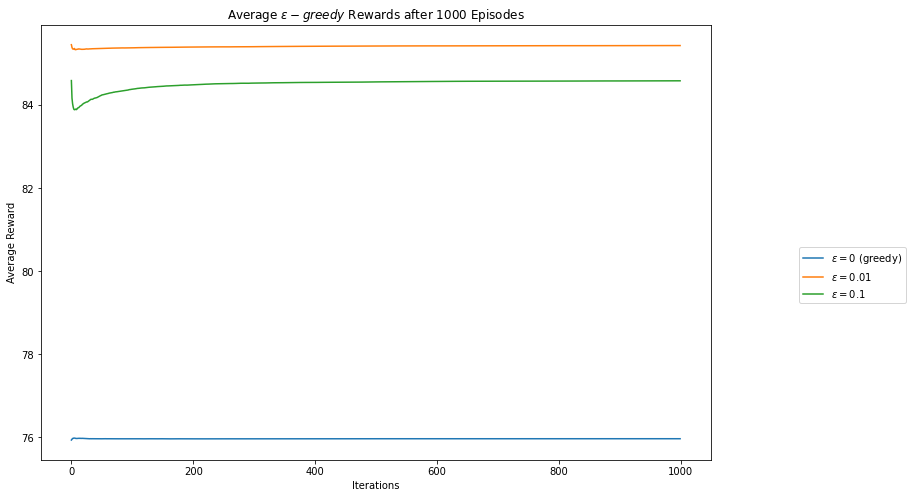

In [5]:
k = 8
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

hmda_mu = [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31]

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, hmda_mu)
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())
    
    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()
    
    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (
        eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (
        eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) 
    + " Episodes")
plt.show()

In [6]:
print(eps_01.k_n)

[990.   3.   1.   1.   1.   2.   1.   1.]


## **RELLEVANT A PARTIR D'AQUÍ**

In [7]:
class PowerSocket:
    """ the base power socket class """
    
    def __init__(self, q, cl, var=1):                
        self.q = q        # the true reward value 
        self.confidence_level = cl          
        self.var = var   
        self.initialize() # reset the socket
        
    def initialize(self):
        self.Q = 0   # the estimate of this socket's reward value                
        self.n = 0   # the number of times this socket has been tried        
    
    def charge(self):
        """ return a random amount of charge """
        
        # the reward is a guassian distribution with unit variance around the true
        # value 'q'
        value = self.var * np.random.randn() + self.q        
        
        # never allow a charge less than 0 to be returned        
        return 0 if value < 0 else value
                    
    def update(self,R):
        """ update this socket after it has returned reward value 'R' """     
    
        # increment the number of times this socket has been tried
        self.n += 1

        # the new estimate of the mean is calculated from the old estimate
        self.Q = (1 - 1.0/self.n) * self.Q + (1.0/self.n) * R

    def uncertainty(self, t): 
        """ calculate the uncertainty in the estimate of this socket's mean """
        if self.n == 0: return float('inf')                         
        return self.confidence_level * (np.sqrt(np.log(t) / self.n))         
        
    def sample(self,t):
        """ the UCB reward is the estimate of the mean reward plus its uncertainty """
        return self.Q + self.uncertainty(t) 

In [8]:
# return the index of the largest value in the supplied list
# - arbitrarily select between the largest values in the case of a tie
# (the standard np.argmax just chooses the first value in the case of a tie)
def random_argmax(value_list):
  """ a random tie-breaking argmax"""
  values = np.asarray(value_list)
  return np.argmax(np.random.random(values.shape) * (values==values.max()))


In [9]:
class SocketTester():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        socket_index = random_argmax([socket.sample(t+1) for socket in self.sockets]) 
        return socket_index     
    
    
    def run( self, number_of_steps, maximum_total_reward = float('inf')):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(number_of_steps)
        
        # loop for the specified number of time-steps
        for t in range(number_of_steps):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            
            # charge from the chosen socket and update its mean reward value
            self.charge_and_update(socket_index)
            
            # test if the accumulated total reward is greater than the maximum
            if self.total_reward > maximum_total_reward:
                break
       
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        return self.total_steps, self.total_reward
  

In [10]:
test = SocketTester(PowerSocket, [85.55, 81.93, 82.84, 79.94, 71.03, 66.35, 74.71, 67.31], 5)
test.run(1000)
test.get_number_of_trials()[-1]

array([959.,  13.,  17.,   6.,   1.,   1.,   2.,   1.])

In [11]:
class SocketTesterBatch():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level):  
        
        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        
        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available = [self.sockets[i] for i in range(len(self.sockets)) if (mask[i])]
        socket_max = random_argmax([socket.sample(t+1) for socket in available]) 
        #print(socket_max)
        socket_index = self.sockets.index(available[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          #print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)


        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [12]:
import math
import random

In [13]:
test2 = SocketTesterBatch(PowerSocket, np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])*100, 5)

decisions = random.choices(range(8), k=1000)
ts,tr,_ = test2.run(decisions)

Presence of each in batch (%): [11.7, 13.2, 10.8, 11.7, 14.8, 11.0, 15.2, 11.6]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 99.09, 100.0, 100.0]
Percentage over total selected (%): [11.71, 13.21, 10.81, 11.71, 14.81, 10.91, 15.22, 11.61]


In [14]:
ts,tr,_ = test2.run(decisions, 0.8)

Presence of each in batch (%): [11.7, 13.2, 10.8, 11.7, 14.8, 11.0, 15.2, 11.6]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 8.18, 100.0, 14.66]
Percentage over total selected (%): [14.62, 16.5, 13.5, 14.62, 18.5, 1.12, 19.0, 2.12]


In [15]:
sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
sample_bias_decisions = random.choices(range(8),weights=sample_bias,k=1000)
#print(sample_bias_decisions)
ts,tr,_ = test2.run(sample_bias_decisions, 0.8)

Presence of each in batch (%): [55.1, 24.7, 1.9, 0.9, 7.8, 9.4, 0.0, 0.2]
Relative approval rate (%): [100.0, 87.85, 100.0, 100.0, 2.56, 1.06, 0.0, 50.0]
Percentage over total selected (%): [68.88, 27.12, 2.38, 1.12, 0.25, 0.12, 0.0, 0.12]


###**NON-STATIC**

In [16]:
#def f(probs, val, ind):
#    probs[ind] += val
#    mask = np.ones(len(probs), bool)
#    mask[ind] = False
#    probs[mask] -= val / (len(probs) - 1)
#    return np.clip(probs, 0, np.infty) / np.sum(np.clip(probs, 0, np.infty))

In [17]:
def cummulative_sample(tester,iter,orig, coef):
  instances_distribution = np.array(orig)
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
      print(i)
      #print(list(instances_distribution))
      pbool=True

    decisions = random.choices(range(8),weights=list(instances_distribution),k=1000)
    ts,tr,ti = tester.run(decisions, 0.8, pbool)
    
    #for i in range(len(ti)):
    #  instances_distribution = f(instances_distribution,ti[i],i)
    instances_distribution = np.add(instances_distribution,ti*coef)
    instances_distribution = np.clip(instances_distribution,0,None)
    instances_distribution = instances_distribution / instances_distribution.sum()

In [18]:
o_sample_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
cummulative_sample(test2,35,o_sample_bias,0.05)

0
Presence of each in batch (%): [54.2, 24.6, 2.6, 1.1, 9.4, 7.7, 0.3, 0.1]
Relative approval rate (%): [100.0, 86.99, 100.0, 100.0, 2.13, 1.3, 100.0, 100.0]
Percentage over total selected (%): [67.75, 26.75, 3.25, 1.38, 0.25, 0.12, 0.38, 0.12]
9
Presence of each in batch (%): [61.3, 22.9, 3.6, 0.9, 5.6, 5.5, 0.1, 0.1]
Relative approval rate (%): [100.0, 59.83, 100.0, 100.0, 3.57, 1.82, 100.0, 100.0]
Percentage over total selected (%): [76.62, 17.12, 4.5, 1.12, 0.25, 0.12, 0.12, 0.12]
18
Presence of each in batch (%): [68.1, 20.9, 3.4, 0.7, 3.9, 2.5, 0.2, 0.3]
Relative approval rate (%): [100.0, 34.45, 100.0, 100.0, 5.13, 4.0, 100.0, 33.33]
Percentage over total selected (%): [85.12, 9.0, 4.25, 0.88, 0.25, 0.12, 0.25, 0.12]
27
Presence of each in batch (%): [77.4, 13.4, 3.2, 1.6, 2.2, 2.1, 0.0, 0.1]
Relative approval rate (%): [98.71, 8.21, 50.0, 37.5, 4.55, 4.76, 0.0, 100.0]
Percentage over total selected (%): [95.5, 1.38, 2.0, 0.75, 0.12, 0.12, 0.0, 0.12]
34
Presence of each in batch

In [19]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,35,no_sample_bias,0.05)

0
Presence of each in batch (%): [11.5, 12.7, 12.9, 12.8, 12.1, 12.0, 13.8, 12.2]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 14.17, 100.0, 20.49]
Percentage over total selected (%): [14.37, 15.88, 16.12, 16.0, 15.12, 2.12, 17.25, 3.12]
9
Presence of each in batch (%): [14.5, 13.9, 13.8, 16.8, 12.5, 6.4, 13.7, 8.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 49.6, 6.25, 100.0, 8.33]
Percentage over total selected (%): [18.12, 17.38, 17.25, 21.0, 7.75, 0.5, 17.12, 0.88]
18
Presence of each in batch (%): [15.7, 15.7, 15.2, 16.7, 9.3, 6.1, 16.3, 5.0]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 9.68, 4.92, 93.25, 6.0]
Percentage over total selected (%): [19.62, 19.62, 19.0, 20.88, 1.12, 0.38, 19.0, 0.38]
27
Presence of each in batch (%): [18.1, 16.2, 21.1, 18.9, 6.0, 2.9, 13.7, 3.1]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 10.0, 6.9, 33.58, 9.68]
Percentage over total selected (%): [22.62, 20.25, 26.38, 23.62, 0.75, 0.25, 5.75, 

In [20]:
no_sample_bias = [1/8]*8
cummulative_sample(test2,150,no_sample_bias,0.05)

0
Presence of each in batch (%): [12.4, 11.9, 12.9, 11.4, 12.1, 13.8, 13.2, 12.3]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 13.77, 100.0, 34.15]
Percentage over total selected (%): [15.5, 14.88, 16.12, 14.25, 15.12, 2.38, 16.5, 5.25]
38
Presence of each in batch (%): [17.6, 18.3, 21.8, 20.6, 4.7, 3.0, 11.6, 2.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 6.38, 3.33, 9.48, 8.33]
Percentage over total selected (%): [22.0, 22.88, 27.25, 25.75, 0.38, 0.12, 1.38, 0.25]
76
Presence of each in batch (%): [32.3, 23.8, 32.7, 8.0, 0.7, 0.3, 1.6, 0.6]
Relative approval rate (%): [100.0, 53.36, 100.0, 21.25, 28.57, 33.33, 12.5, 16.67]
Percentage over total selected (%): [40.38, 15.88, 40.88, 2.12, 0.25, 0.12, 0.25, 0.12]
114
Presence of each in batch (%): [49.0, 10.6, 37.0, 2.3, 0.3, 0.1, 0.6, 0.1]
Relative approval rate (%): [100.0, 49.06, 64.59, 56.52, 33.33, 100.0, 50.0, 100.0]
Percentage over total selected (%): [61.25, 6.5, 29.88, 1.62, 0.12, 0.12, 0.38, 0.

In [21]:
def nonstatic(iter, rewards_d_o, r_coef, instances_d_o, i_coef):
  rewards_d = np.array(rewards_d_o)
  instances_d = np.array(instances_d_o)

  #iter = 1000
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        #print(list(instances_distribution))
        pbool=True

    updated_test = SocketTesterBatch(PowerSocket, list(rewards_d), 5)
    decisions = random.choices(range(8),weights=list(instances_d),k=1000)
    ts,tr,ti = updated_test.run(decisions, 0.8, pbool)

    increments = ti
    #increments = np.subtract(np.array(updated_test.get_socket_percentages()),0.5)
    #print(increments)

    rewards_d = np.add(rewards_d,increments*r_coef*100)
    rewards_d = np.clip(rewards_d,0,100)
    #print(rewards_d)

    instances_d = np.add(instances_d,increments*i_coef)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [22]:
rewards_bias = np.array([.8555, .8193, .8284, .7994, .7103, .6635, .7471, .6731])*100
rewards_nonbias = [100/2]*8

instances_bias = [0.555, 0.24, 0.023, 0.011, 0.087, 0.081, 0.001, 0.001]
instances_nonbias = [1/8]*8

In [23]:
nonstatic(100, rewards_nonbias, 0, instances_nonbias, 0)

0
Presence of each in batch (%): [13.4, 12.4, 12.9, 13.3, 11.5, 11.9, 11.5, 13.1]
Relative approval rate (%): [74.63, 95.16, 88.37, 75.94, 94.78, 89.92, 73.04, 51.15]
Percentage over total selected (%): [12.5, 14.75, 14.25, 12.62, 13.63, 13.38, 10.5, 8.38]
25
Presence of each in batch (%): [12.9, 12.0, 12.4, 9.9, 13.5, 12.8, 13.3, 13.2]
Relative approval rate (%): [88.37, 94.17, 76.61, 95.96, 66.67, 80.47, 70.68, 72.73]
Percentage over total selected (%): [14.25, 14.12, 11.88, 11.88, 11.25, 12.88, 11.75, 12.0]
50
Presence of each in batch (%): [12.5, 13.4, 12.6, 11.8, 11.5, 12.0, 14.5, 11.7]
Relative approval rate (%): [90.4, 98.51, 75.4, 91.53, 83.48, 69.17, 51.72, 83.76]
Percentage over total selected (%): [14.12, 16.5, 11.88, 13.5, 12.0, 10.38, 9.38, 12.25]
75
Presence of each in batch (%): [11.9, 11.5, 12.6, 11.7, 12.1, 13.0, 12.8, 14.4]
Relative approval rate (%): [82.35, 84.35, 53.97, 79.49, 81.82, 87.69, 78.91, 90.28]
Percentage over total selected (%): [12.25, 12.12, 8.5, 11.62

In [24]:
nonstatic(2500, rewards_nonbias, 0, instances_bias, 0.01)

0
Presence of each in batch (%): [54.0, 26.1, 1.8, 1.0, 7.5, 9.4, 0.1, 0.1]
Relative approval rate (%): [62.96, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [42.5, 32.62, 2.25, 1.25, 9.38, 11.75, 0.12, 0.12]
625
Presence of each in batch (%): [21.6, 22.5, 11.9, 4.7, 17.9, 20.4, 0.3, 0.7]
Relative approval rate (%): [60.19, 74.22, 100.0, 100.0, 93.3, 78.43, 100.0, 100.0]
Percentage over total selected (%): [16.25, 20.88, 14.88, 5.88, 20.88, 20.0, 0.38, 0.88]
1250
Presence of each in batch (%): [14.7, 15.5, 15.9, 17.2, 16.9, 14.8, 2.5, 2.5]
Relative approval rate (%): [77.55, 100.0, 78.62, 65.7, 76.33, 77.03, 100.0, 100.0]
Percentage over total selected (%): [14.25, 19.38, 15.62, 14.12, 16.12, 14.25, 3.12, 3.12]
1875
Presence of each in batch (%): [14.4, 13.5, 13.4, 12.6, 13.5, 14.2, 8.5, 9.9]
Relative approval rate (%): [52.08, 82.22, 75.37, 86.51, 74.81, 83.8, 100.0, 100.0]
Percentage over total selected (%): [9.38, 13.88, 12.62, 13.63, 12.62, 14

In [25]:
nonstatic(100, rewards_bias, 0, instances_nonbias, 0)

0
Presence of each in batch (%): [12.5, 12.3, 13.6, 13.7, 12.0, 10.9, 11.6, 13.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 11.93, 100.0, 22.39]
Percentage over total selected (%): [15.62, 15.38, 17.0, 17.12, 15.0, 1.62, 14.5, 3.75]
25
Presence of each in batch (%): [10.5, 10.8, 13.3, 13.0, 13.7, 12.8, 13.0, 12.9]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 14.06, 100.0, 30.23]
Percentage over total selected (%): [13.12, 13.5, 16.62, 16.25, 17.12, 2.25, 16.25, 4.88]
50
Presence of each in batch (%): [11.1, 12.5, 13.1, 13.0, 11.3, 11.2, 13.5, 14.3]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 20.54, 100.0, 22.38]
Percentage over total selected (%): [13.88, 15.62, 16.38, 16.25, 14.12, 2.88, 16.88, 4.0]
75
Presence of each in batch (%): [14.3, 12.0, 11.5, 12.0, 15.6, 11.1, 12.0, 11.5]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 9.91, 100.0, 13.04]
Percentage over total selected (%): [17.88, 15.0, 14.37, 15.0,

In [26]:
nonstatic(100, rewards_bias, 0.1, instances_nonbias, 0)

0
Presence of each in batch (%): [12.4, 12.3, 12.3, 13.1, 12.3, 12.8, 12.4, 12.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 10.94, 100.0, 30.65]
Percentage over total selected (%): [15.5, 15.38, 15.38, 16.38, 15.38, 1.75, 15.5, 4.75]
25
Presence of each in batch (%): [13.6, 11.5, 13.9, 11.2, 11.7, 12.3, 13.0, 12.8]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 0.81, 100.0, 39.06]
Percentage over total selected (%): [17.0, 14.37, 17.38, 14.0, 14.62, 0.12, 16.25, 6.25]
50
Presence of each in batch (%): [10.9, 13.9, 10.4, 13.8, 10.8, 13.7, 14.5, 12.0]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 0.73, 100.0, 46.67]
Percentage over total selected (%): [13.63, 17.38, 13.0, 17.25, 13.5, 0.12, 18.12, 7.0]
75
Presence of each in batch (%): [12.2, 13.0, 12.8, 11.8, 12.4, 13.0, 14.4, 10.4]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 0.77, 100.0, 31.73]
Percentage over total selected (%): [15.25, 16.25, 16.0, 14.75, 15

In [27]:
nonstatic(100, rewards_bias, 0, instances_bias, 0.01)

0
Presence of each in batch (%): [58.3, 21.2, 1.8, 1.8, 8.6, 8.1, 0.0, 0.2]
Relative approval rate (%): [100.0, 83.96, 100.0, 100.0, 1.16, 1.23, 0.0, 50.0]
Percentage over total selected (%): [72.88, 22.25, 2.25, 2.25, 0.12, 0.12, 0.0, 0.12]
25
Presence of each in batch (%): [57.4, 25.2, 1.9, 1.6, 7.7, 6.2, 0.0, 0.0]
Relative approval rate (%): [100.0, 75.0, 100.0, 100.0, 1.3, 1.61, 0.0, 0.0]
Percentage over total selected (%): [71.75, 23.62, 2.38, 2.0, 0.12, 0.12, 0.0, 0.0]
50
Presence of each in batch (%): [63.4, 21.7, 2.4, 1.2, 6.5, 4.7, 0.1, 0.0]
Relative approval rate (%): [100.0, 58.06, 100.0, 100.0, 3.08, 2.13, 100.0, 0.0]
Percentage over total selected (%): [79.25, 15.75, 3.0, 1.5, 0.25, 0.12, 0.12, 0.0]
75
Presence of each in batch (%): [65.5, 22.3, 3.5, 1.0, 3.8, 3.9, 0.0, 0.0]
Relative approval rate (%): [100.0, 43.5, 100.0, 100.0, 5.26, 2.56, 0.0, 0.0]
Percentage over total selected (%): [81.88, 12.12, 4.38, 1.25, 0.25, 0.12, 0.0, 0.0]
99
Presence of each in batch (%): [72.

In [28]:
nonstatic(100, rewards_bias, 0.01, instances_bias, 0)

0
Presence of each in batch (%): [54.5, 24.8, 2.4, 1.4, 9.3, 7.5, 0.1, 0.0]
Relative approval rate (%): [100.0, 85.89, 100.0, 100.0, 2.15, 1.33, 100.0, 0.0]
Percentage over total selected (%): [68.12, 26.62, 3.0, 1.75, 0.25, 0.12, 0.12, 0.0]
25
Presence of each in batch (%): [53.2, 26.1, 2.3, 0.8, 10.1, 7.2, 0.3, 0.0]
Relative approval rate (%): [100.0, 88.89, 100.0, 100.0, 0.99, 1.39, 100.0, 0.0]
Percentage over total selected (%): [66.5, 29.0, 2.88, 1.0, 0.12, 0.12, 0.38, 0.0]
50
Presence of each in batch (%): [52.3, 27.0, 2.0, 0.9, 8.8, 8.9, 0.1, 0.0]
Relative approval rate (%): [100.0, 90.74, 100.0, 100.0, 1.14, 1.12, 100.0, 0.0]
Percentage over total selected (%): [65.38, 30.63, 2.5, 1.12, 0.12, 0.12, 0.12, 0.0]
75
Presence of each in batch (%): [56.3, 22.7, 3.7, 0.8, 7.9, 8.6, 0.0, 0.0]
Relative approval rate (%): [100.0, 83.7, 100.0, 100.0, 1.27, 1.16, 0.0, 0.0]
Percentage over total selected (%): [70.38, 23.75, 4.62, 1.0, 0.12, 0.12, 0.0, 0.0]
99
Presence of each in batch (%): 

In [29]:
nonstatic(100, rewards_bias, 0.01, instances_bias, 0.01)

0
Presence of each in batch (%): [59.3, 23.5, 2.6, 0.8, 7.7, 5.9, 0.2, 0.0]
Relative approval rate (%): [100.0, 71.49, 100.0, 100.0, 2.6, 1.69, 100.0, 0.0]
Percentage over total selected (%): [74.12, 21.0, 3.25, 1.0, 0.25, 0.12, 0.25, 0.0]
25
Presence of each in batch (%): [58.0, 25.5, 1.6, 1.3, 6.6, 6.7, 0.2, 0.1]
Relative approval rate (%): [100.0, 72.94, 100.0, 100.0, 1.52, 1.49, 100.0, 100.0]
Percentage over total selected (%): [72.5, 23.25, 2.0, 1.62, 0.12, 0.12, 0.25, 0.12]
50
Presence of each in batch (%): [60.2, 23.0, 3.6, 1.3, 5.8, 5.8, 0.3, 0.0]
Relative approval rate (%): [100.0, 62.61, 100.0, 100.0, 1.72, 1.72, 100.0, 0.0]
Percentage over total selected (%): [75.25, 18.0, 4.5, 1.62, 0.12, 0.12, 0.38, 0.0]
75
Presence of each in batch (%): [67.5, 20.1, 3.0, 1.4, 3.4, 4.4, 0.2, 0.0]
Relative approval rate (%): [100.0, 38.31, 100.0, 100.0, 2.94, 2.27, 100.0, 0.0]
Percentage over total selected (%): [84.38, 9.62, 3.75, 1.75, 0.12, 0.12, 0.25, 0.0]
99
Presence of each in batch (

###**SOLUTION?**

In [30]:
class SocketTesterBatchSOLUTION():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_order, confidence_level, sub_opt):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(q, confidence_level) for q in socket_order]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        #CONSTRAINT A
        curr_percentages = self.socket_stats[:,:,1][t]/t
        mean_percentages = np.mean(curr_percentages)
        dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

        #CONSTRAINT B
        mean_selections = np.mean(self.get_number_of_trials()[t])
        dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

        #DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
        #dif = dif_percentages #rang 10-30-50
        dif = dif_selections   #rang 0-0.01-0.1

        #print(dif)

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        socket_max = random_argmax([self.sockets[socket].sample(t+1)+self.subopt_coef*dif[socket] for socket in available]) 
        #socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 

        #print(socket_max)
        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("possibles",self.possibles)
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)
          #print(self.return_increments(decisions_to_consider))

        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [31]:
sol_test = SocketTesterBatch(PowerSocket, list(rewards_bias), 5)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [56.7, 22.4, 1.9, 1.2, 9.4, 8.0, 0.2, 0.2]
Relative approval rate (%): [100.0, 87.5, 100.0, 100.0, 2.13, 1.25, 100.0, 50.0]
Percentage over total selected (%): [70.88, 24.5, 2.38, 1.5, 0.25, 0.12, 0.25, 0.12]


In [32]:
sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 0)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [55.6, 24.5, 1.5, 1.7, 8.7, 7.6, 0.0, 0.4]
Times selected: [556. 208.  15.  17.   2.   1.   0.   1.]
Relative approval rate (%): [100.0, 84.9, 100.0, 100.0, 2.3, 1.32, 0.0, 25.0]
Percentage over total selected (%): [69.41, 25.97, 1.87, 2.12, 0.25, 0.12, 0.0, 0.12]


In [33]:
sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 0.01)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [54.0, 23.7, 2.3, 0.9, 10.0, 9.0, 0.0, 0.1]
Times selected: [540. 224.  23.   9.   2.   1.   0.   1.]
Relative approval rate (%): [100.0, 94.51, 100.0, 100.0, 2.0, 1.11, 0.0, 100.0]
Percentage over total selected (%): [67.42, 27.97, 2.87, 1.12, 0.25, 0.12, 0.0, 0.12]


In [34]:
sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 0.1)
decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [54.7, 24.4, 2.0, 1.1, 9.3, 8.4, 0.0, 0.1]
Times selected: [347. 244.  20.  11.  93.  84.   0.   1.]
Relative approval rate (%): [63.44, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0, 100.0]
Percentage over total selected (%): [43.32, 30.46, 2.5, 1.37, 11.61, 10.49, 0.0, 0.12]


In [35]:
#sol_test = SocketTesterBatchSOLUTION(PowerSocket, list(rewards_bias), 5, 50)
#decisions = random.choices(range(8),weights=list(instances_bias),k=1000)
#ts,tr,ti = sol_test.run(decisions, 0.8, True)

curr_percentages = self.socket_stats[:,:,1][t]/t
mean_percentages = np.mean(curr_percentages)
dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

mean_selections = np.mean(self.get_number_of_trials()[t])
dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

#DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
//dif = dif_percentages #rang 10-30-50

dif = dif_selections   #rang 0-0.01-0.1

In [116]:
class SocketTesterBatchSOLUTION_var():
    """ create and test a set of sockets over a single test run """

    def __init__(self, socket, socket_qs, confidence_level, sub_opt, socket_vars):  
        
        self.subopt_coef = sub_opt

        # create supplied socket type with a mean value defined by socket order 
        self.sockets = [socket(socket_qs[s], confidence_level, socket_vars[s]) for s in range(len(socket_qs))]     
        
        # set the number of sockets equal to the number created
        self.number_of_sockets = len(self.sockets)

        self.number_of_stats = 2                 
            
    def initialize_run(self, number_of_steps):
        """ reset counters at the start of a run """
        
        # save the number of steps over which the run will take place
        self.number_of_steps = number_of_steps
        
        # reset the actual number of steps that the test ran for
        self.total_steps = 0
        
        # monitor the total reward obtained over the run
        self.total_reward = 0
        
        # the current total reward at each timestep of the run
        self.total_reward_per_timestep = []
        
        # the actual reward obtained at each timestep
        self.reward_per_timestep = []
           
        # stats for each time-step
        # - by default records: estimate, number of trials
        self.socket_stats = np.zeros(shape=(number_of_steps+1, 
                                            self.number_of_sockets, 
                                            self.number_of_stats))
        
        # ensure that all sockets are re-initialized
        for socket in self.sockets: socket.initialize()
            
                                
    def charge_and_update(self,socket_index):
        """ charge from & update the specified socket and associated parameters """
        
        # charge from the chosen socket and update its mean reward value
        reward = self.sockets[socket_index].charge()
        self.sockets[socket_index].update(reward)

        # update the total reward
        self.total_reward += reward   
        
        # store the current total reward at this timestep
        self.total_reward_per_timestep.append(self.total_reward)
        
        # store the reward obtained at this timestep
        self.reward_per_timestep.append(reward)        
        
        
    def get_socket_stats( self, t ):
        """ get the current information from each socket """        
        socket_stats = [[socket.Q, socket.n] for socket in self.sockets]
        return socket_stats     
    
    def get_mean_reward( self ):
        """ the total reward averaged over the number of time steps """
        return (self.total_reward/self.total_steps)
    
    def get_total_reward_per_timestep( self ):
        """ the cumulative total reward at each timestep of the run """
        return self.total_reward_per_timestep
    
    def get_reward_per_timestep( self ):
        """ the actual reward obtained at each timestep of the run """
        return self.reward_per_timestep
    
    def get_estimates(self):
        """ get the estimate of each socket's reward at each timestep of the run """
        return self.socket_stats[:,:,0]  
    
    def get_number_of_trials(self):
        """ get the number of trials of each socket at each timestep of the run """
        return self.socket_stats[:,:,1]          
                
    def get_socket_percentages( self ):
        """ get the percentage of times each socket was tried over the run """
        return (self.socket_stats[:,:,1][self.total_steps]/self.total_steps)        
    
    def get_time_steps( self ):
        """ get the number of time steps that the test ran for """
        return self.total_steps
    
    def select_socket( self, t ):
        """ Greedy Socket Selection"""
        #CONSTRAINT A
        curr_percentages = self.socket_stats[:,:,1][t]/t
        mean_percentages = np.mean(curr_percentages)
        dif_percentages = np.subtract(mean_percentages,self.socket_stats[:,:,1][t]/t)

        #CONSTRAINT B
        mean_selections = np.mean(self.get_number_of_trials()[t])
        dif_selections = np.subtract(mean_selections,self.get_number_of_trials()[t])

        #CONSTRAINT C
        #presence = np.array([i/sum(self.possibles) for i in self.possibles])
        #selected_presence = np.array(self.socket_stats[:,:,1][t]/t)
        #dif_presence = np.subtract(presence,selected_presence)

        #DUES CONSTRAINTS, UNA PER PERCENTATGES, L'ALTRE n SELECTIONS
        #dif = dif_percentages #rang 10-30-50
        dif = dif_selections   #rang 0-0.01-0.1
        ###dif = dif_presence

        #print(dif)

        # choose the socket with the current highest mean reward or arbitrarily
        # select a socket in the case of a tie            
        mask = [self.get_number_of_trials()[t][i]<self.possibles[i] for i in range(len(self.sockets))]
        #print(mask)
        available_sockets = [self.sockets[s] for s in range(len(self.sockets)) if (mask[s])]
        available = [i for i in range(len(self.sockets)) if (mask[i])]

        samples = [self.sockets[socket].sample(t+1)+self.subopt_coef*dif[socket] for socket in available]
        """print()
        print("presence",presence)
        print("selected_presence",selected_presence)
        print("dif",dif)
        print("samples",samples)"""
        socket_max = random_argmax(samples) 
        #socket_max = random_argmax([self.sockets[socket].sample(t+1) for socket in available]) 

        #print(socket_max)
        socket_index = self.sockets.index(available_sockets[socket_max])
        return socket_index     
    
    def return_increments(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff

    def return_increments_distr(self, decisions_to_consider):
        presence = np.array([i/len(decisions_to_consider) for i in self.possibles])
        selected_presence = np.array(self.get_socket_percentages())
        diff = np.subtract(selected_presence, presence)
        #print(diff)
        #print(diff.sum())
        return diff
    
    def run( self, decisions_to_consider, max_percent_decisions=1, prints_bool = True):  
        """ perform a single run, over the set of sockets, 
            for the defined number of steps """
        
        # reset the run counters
        self.initialize_run(len(decisions_to_consider))

        self.possibles = [0]*8 #TODO: DEPENDS ON N OF CLUSTER (DECISIONS.UNIQUE() ISNT ENOUGH BECAUSE IT CAN LACK SOME INSTANCES)
        for i in np.unique(np.array(decisions_to_consider)):
          self.possibles[i] = decisions_to_consider.count(i) 
        #print("possibles",self.possibles)

        usos = 0
        usos_maxims = math.floor(max_percent_decisions*len(decisions_to_consider))
        #print(usos_maxims)

        # loop for the specified number of time-steps
        for t in range(1,len(decisions_to_consider)):

            # get information about all sockets at the start of the time step
            self.socket_stats[t] = self.get_socket_stats(t)            
            
            # select a socket
            socket_index = self.select_socket(t)
            #if(decisions_to_consider[t]==socket_index):
            if(self.get_number_of_trials()[t][socket_index]<self.possibles[socket_index]):
              # charge from the chosen socket and update its mean reward value
              self.charge_and_update(socket_index)
              usos+=1
              
              if usos > usos_maxims:
                  #print(usos,usos_maxims)
                  break
        # save the actual number of steps that have been run
        self.total_steps = t    
    
        # get the stats for each socket at the end of the run        
        self.socket_stats[t+1] = self.get_socket_stats(t+1)           
        
        if(prints_bool):
          #print("possibles",self.possibles)
          #print("Reward distribution:",[s.q for s in self.sockets])
          #print("Intances of each cluster:",self.possibles)
          print("Presence of each in batch (%):",[100*i/len(decisions_to_consider) for i in self.possibles])
          print("Times selected:",self.get_number_of_trials()[t])
          print("Relative approval rate (%):",[round(100*self.get_number_of_trials()[t][i]/self.possibles[i],2) if self.possibles[i]>0.0 else 0.0 for i in range(len(self.possibles))])
          print("Percentage over total selected (%):",[round(100*p,2) for p in self.get_socket_percentages()])
          #print("For a total reward:",self.total_reward)
          #print(self.return_increments(decisions_to_consider))
          print("Estimates:",list(self.get_estimates()[t]))

        return self.total_steps, self.total_reward, self.return_increments(decisions_to_consider)
  

In [74]:
variances = [20]*8
#variances = [1]*8
sol_test = SocketTesterBatchSOLUTION_var(PowerSocket, list(rewards_bias), 5, 0, variances) #high variance+sampling bias super injust (la variance de classes menys popualtes afecta mes q altres)
decisions = random.choices(range(8),weights=list(instances_nonbias),k=1000)
ts,tr,ti = sol_test.run(decisions, 0.8, True)

Presence of each in batch (%): [13.3, 10.5, 13.9, 13.2, 13.7, 12.6, 11.4, 11.4]
Times selected: [133. 105. 139. 132. 137.   1.  39. 114.]
Relative approval rate (%): [100.0, 100.0, 100.0, 100.0, 100.0, 0.79, 34.21, 100.0]
Percentage over total selected (%): [16.6, 13.11, 17.35, 16.48, 17.1, 0.12, 4.87, 14.23]
Estimates: [133.03988200379098, 139.99304040361446, 124.19903537916039, 130.79287806714166, 121.35532503740323, 0.0, 124.21457833760142, 142.77679432246293]


In [108]:
def nonstatic_sol(iter, rewards_d_o, r_coef, instances_d_o, i_coef, sub_opt, s_variances):
  rewards_d = np.array(rewards_d_o)
  instances_d = np.array(instances_d_o)

  #iter = 1000
  for i in range(iter):
    pbool=False
    if(i%math.ceil(iter/4)==0 or i==iter-1):
        print(i)
        #print(list(instances_distribution))
        pbool=True

    updated_test = SocketTesterBatchSOLUTION_var(PowerSocket, list(rewards_d), 5, sub_opt, s_variances)
    decisions = random.choices(range(8),weights=list(instances_d),k=5000)
    ts,tr,ti = updated_test.run(decisions, 0.8, pbool)

    increments = ti
    #increments = np.subtract(np.array(updated_test.get_socket_percentages()),0.5)
    #print(increments)

    rewards_d = np.add(rewards_d,increments*r_coef*100)
    rewards_d = np.clip(rewards_d,0,100)
    #print(rewards_d)

    instances_d = np.add(instances_d,increments*i_coef)
    instances_d = np.clip(instances_d,0,None)
    instances_d = instances_d / instances_d.sum()

In [80]:
variances = [1]*8
nonstatic_sol(500, rewards_bias, 0.01, instances_bias, 0.01, 0, variances)

0
Presence of each in batch (%): [57.6, 22.0, 2.5, 1.3, 7.5, 8.9, 0.2, 0.0]
Times selected: [576. 181.  25.  13.   2.   1.   2.   0.]
Relative approval rate (%): [100.0, 82.27, 100.0, 100.0, 2.67, 1.12, 100.0, 0.0]
Percentage over total selected (%): [71.91, 22.6, 3.12, 1.62, 0.25, 0.12, 0.25, 0.0]
Estimates: [85.49518905118711, 82.03815660657311, 82.86707418620183, 79.60747208301376, 70.79377687309469, 65.0427889399137, 74.47860434944428, 0.0]
125
Presence of each in batch (%): [74.4, 15.1, 3.6, 2.1, 2.6, 2.1, 0.1, 0.0]
Times selected: [744.   2.  36.  15.   1.   1.   1.   0.]
Relative approval rate (%): [100.0, 1.32, 100.0, 71.43, 3.85, 4.76, 100.0, 0.0]
Percentage over total selected (%): [92.88, 0.25, 4.49, 1.87, 0.12, 0.12, 0.12, 0.0]
Estimates: [99.98243529142299, 72.21096899964982, 83.72453719964892, 80.30949826273186, 64.87157257011879, 60.290710091182326, 72.47372147301242, 0.0]
250
Presence of each in batch (%): [92.6, 4.3, 0.7, 0.7, 1.1, 0.2, 0.3, 0.1]
Times selected: [793. 

In [81]:
variances = [1]*8
nonstatic_sol(500, rewards_bias, 0.01, instances_bias, 0.01, 0.1, variances)

0
Presence of each in batch (%): [54.2, 24.0, 2.6, 1.0, 9.7, 8.5, 0.0, 0.0]
Times selected: [342. 240.  26.  10.  97.  85.   0.   0.]
Relative approval rate (%): [63.1, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0, 0.0]
Percentage over total selected (%): [42.7, 29.96, 3.25, 1.25, 12.11, 10.61, 0.0, 0.0]
Estimates: [85.60066446620841, 81.9419599710013, 82.78383912654644, 80.75138128031263, 71.09508653917266, 66.41916729041793, 0.0, 0.0]
125
Presence of each in batch (%): [41.0, 30.7, 3.4, 1.8, 11.6, 11.2, 0.0, 0.3]
Times selected: [210. 307.  34.  18. 116. 112.   0.   3.]
Relative approval rate (%): [51.22, 100.0, 100.0, 100.0, 100.0, 100.0, 0.0, 100.0]
Percentage over total selected (%): [26.22, 38.33, 4.24, 2.25, 14.48, 13.98, 0.0, 0.37]
Estimates: [69.29129012398582, 90.79008451486243, 83.72816034997189, 80.74666358650974, 74.05717200064305, 69.18080690838457, 0.0, 67.64472446133036]
250
Presence of each in batch (%): [14.6, 47.0, 4.6, 1.4, 16.6, 15.2, 0.4, 0.2]
Times selected: [  1. 416.

In [118]:
variances = [10]*8
##(5000 per iter)
nonstatic_sol(1000, rewards_bias, 0.02, instances_bias, 0.02, 0.1, variances)

0
Presence of each in batch (%): [56.28, 23.42, 2.1, 1.08, 8.6, 8.36, 0.08, 0.08]
Times selected: [1814. 1171.  105.   54.  430.  418.    4.    4.]
Relative approval rate (%): [64.46, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [45.34, 29.27, 2.62, 1.35, 10.75, 10.45, 0.1, 0.1]
Estimates: [85.6653438187958, 81.63725206455976, 83.60750790788398, 79.94279824165241, 71.33481096553903, 66.17807628145276, 73.15453459833698, 73.2580950686534]
250
Presence of each in batch (%): [16.18, 25.78, 7.78, 3.86, 23.26, 22.28, 0.46, 0.4]
Times selected: [572. 936. 389. 193. 961. 906.  23.  20.]
Relative approval rate (%): [70.7, 72.61, 100.0, 100.0, 82.63, 81.33, 100.0, 100.0]
Percentage over total selected (%): [14.3, 23.39, 9.72, 4.82, 24.02, 22.64, 0.57, 0.5]
Estimates: [46.67425914515874, 83.2675316138825, 88.91627655836699, 82.4167321250893, 85.72554232557523, 80.25160680485948, 75.04367068722672, 68.09198379549134]
500
Presence of each in batch (%): [8.64

In [111]:
variances = [10]*8
nonstatic_sol(1000, rewards_bias, 0.04, instances_bias, 0.04, 100, variances)

0
Presence of each in batch (%): [55.62, 24.98, 2.2, 0.9, 8.64, 7.44, 0.1, 0.12]
Times selected: [1781. 1249.  110.   45.  432.  372.    5.    6.]
Relative approval rate (%): [64.04, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
Percentage over total selected (%): [44.51, 31.22, 2.75, 1.12, 10.8, 9.3, 0.12, 0.15]
Estimates: [85.07438563279035, 82.10877309420388, 82.05028240188253, 78.74859166202384, 70.62304686392397, 66.90883151438435, 75.36155959298216, 72.2851985537412]
250
Presence of each in batch (%): [17.76, 16.98, 16.9, 12.52, 16.82, 16.8, 1.08, 1.14]
Times selected: [652. 653. 653. 626. 653. 652.  54.  57.]
Relative approval rate (%): [73.42, 76.91, 77.28, 100.0, 77.65, 77.62, 100.0, 100.0]
Percentage over total selected (%): [16.3, 16.32, 16.32, 15.65, 16.32, 16.3, 1.35, 1.42]
Estimates: [46.7662088370066, 75.84838514867889, 97.0919354699691, 92.66968563754833, 78.79597727238253, 74.52030749077258, 74.20485618151271, 68.97825492851017]
500
Presence of each in batch (%): [1